# Find most important feature in a model predictions using influence functions

Pang Wei Koh and Percy Lian show in their ["Understanding Black-box Predictions via Influence Functions"](https://arxiv.org/pdf/1703.04730.pdf) (ICML 2017) that influence functions can be used to approximate the learning effect of training data onto the predictions.
An extension of this is the ability to approximate the effect of a given perturbation on a training point.

The original authors demonstrate how this also enables engineering adversarial training attack. The attack consists in finding the most influential training input for a given test point prediction. Then approximating the perturbation that has the maximally negative learning effect on learning the test point.

The author suggest the possibility of using influence functions to approximate the effect of perturbing the training point has a way to analyse the training effects of features.


We use the original code from the offical authors repository for the model classes and various utilities. We use the Kaggle [Titanic dataset](https://www.kaggle.com/c/titanic/data) to experiment on the idea of using influence functions to approximate the effect of features on learning in a blackbox model.

**Plan**

1. Preprocess data
2. Train model (logistic regression)
3. Test model
4. Engineer adversarial training training data to degrade the performance of the model.
5. Analyse the noise added to the feature as a characterization of the influence of feature in learning for the model.





3. For each correctly labelled test point:
       Find most their influential training points
       Approximate the perturbation effect on each point
       
+ For each feature:
	For each train point:
	    Get influence on loss of perturbation of given training point on given feature
+ Get stats:
	+ Average by feature of their influence on z-test
	+(other stats)
    

### Preparation of the dataset

In [1]:
import pandas as pd
import numpy as np

fpath_titanic = "/home/eolus/Desktop/Dauphine/datamining/projets/blackBox/data/train.csv"
train_df = pd.read_csv(fpath_titanic)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
def extract_prefix(name):
    import re
    try:
        return re.search('(Mr\.)|(Mrs\.)|(Miss\.)', name).group()
    except:
        return ""


train_df['Prefix'] = train_df.Name.apply(extract_prefix)

for cat_col in ['Sex', 'Embarked', 'Prefix' ]:
    train_df[cat_col] = pd.factorize(train_df[cat_col])[0]
    
train_df['Age'].fillna(train_df.Age.mean(), inplace=True)    

In [3]:
features = ['Prefix', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

X = np.array(train_df[features])
y = np.array((train_df.Survived > 0).astype('int32'))

In [4]:
# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Need to train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Create dataset objects
import sys
sys.path.append("..")

#from influence indataset as dataset
from influence.dataset import DataSet
import numpy as np
lr_train = DataSet(X_train, np.array(y_train, dtype=int))
lr_test = DataSet(X_test, np.array(y_test, dtype=int))
lr_validation = None

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

### Train model of reference

In [6]:
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS

num_classes = 2
input_dim = len(features)

weight_decay = 0.01
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

tf.reset_default_graph()

tf_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='tmp',
    log_dir='tmp',
    model_name='titanic')

tf_model.train()


Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Total number of parameters: 8
Using normal model
LBFGS training took [10] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.49039847
Train loss (w/o reg) on all data: 0.48153788
Test loss (w/o reg) on all data: 0.43405235
Train acc on all data:  0.7701342281879194
Test acc on all data:   0.8033898305084746
Norm of the mean of gradients: 4.7753606e-06
Norm of the params: 1.33121


/home/eolus/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [105]:
#IM trying to find correctly labeled records
tf_model.data_sets.train.pred == y_train

AttributeError: 'DataSet' object has no attribute 'pred'

### Select 10 most influential train point

In [7]:
test_idx = 30

num_train = len(tf_model.data_sets.train.labels)

influences = tf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train

influences.shape

Norm of test gradient: 0.39605683
Function value: -0.3568248748779297
Split function value: 0.3602283000946045, -0.7170532
Predicted loss diff on train_idx 5: 0.0003191828977741651
Function value: -0.37047380208969116
Split function value: 0.3354359269142151, -0.7059097
Predicted loss diff on train_idx 5: 9.387484032835736e-05
Function value: -0.3753376007080078
Split function value: 0.3806424140930176, -0.75598
Predicted loss diff on train_idx 5: 0.00011002546138811431
Function value: -0.3759527802467346
Split function value: 0.374022901058197, -0.7499757
Predicted loss diff on train_idx 5: 0.00010968234715045698
Function value: -0.3759610950946808
Split function value: 0.3758927881717682, -0.7518539
Predicted loss diff on train_idx 5: 0.00011302833289108021
Function value: -0.3759611248970032
Split function value: 0.3759269118309021, -0.75188804
Predicted loss diff on train_idx 5: 0.00011294900170908679
Function value: -0.37596118450164795
Split function value: 0.37594401836395264, -

(596,)

In [8]:
# Do we want look at absolute value or only positive influence???
top_influence_ix = [el[0] for el in sorted(list(enumerate(influences.tolist())), key=lambda x : x[1], reverse=True)[:30]]

### Influence perturbation

In [9]:
# Check poison_with_influence_proj_gradient_step (GenericNeuralNet)
# Check self.gradient_wrt_input_op (gradient gives direction of feature perturbation)

In [10]:
test_idx = 30

num_train = len(tf_model.data_sets.train.labels)

influences_grad = tf_model.get_grad_of_influence_wrt_input(
    np.arange(num_train),
    [test_idx], 
    force_refresh=False)

Norm of test gradient: 0.39605683
Loaded inverse HVP from tmp/titanic-cg-normal_loss-test-[30].npz
Inverse HVP took 0.0016243457794189453 sec


In [11]:
influence_grad_top_features = influences_grad[top_influence_ix, :]

avg_inf_pert = [np.mean(col) for col in influence_grad_top_features.T]
features_avg_inf = zip(features, avg_inf_pert)

sorted_logit_influence = sorted(features_avg_inf, key=lambda x : abs(x[1]), reverse=True)

### Benchmark feature importance

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

estimator = LogisticRegression()
selector = RFECV(estimator, step=3, cv=3)
selector = selector.fit(X_train, y_train)
selector.score(X_test, y_test)

0.8203389830508474

In [13]:
selector.estimator_.coef_[0]

array([ 0.38991178, -0.71842588,  1.00059846, -0.29151786, -0.37872978,
       -0.0958028 ,  0.1934243 ,  0.16377468])

In [14]:
features_importance = zip(features, selector.estimator_.coef_[0])
sorted_logit_coefs = sorted(features_importance, key=lambda x : abs(x[1]), reverse=True)
print("\nLogistic Regression Coeffs")
print("============================")
for el in sorted_logit_coefs:
    print(el)

    
print("\nInfluence function")
print("============================")
for el in sorted_logit_influence:
    print(el)


Logistic Regression Coeffs
('Sex', 1.0005984599032838)
('Pclass', -0.7184258754192752)
('Prefix', 0.3899117807908663)
('SibSp', -0.3787297807952296)
('Age', -0.2915178644724024)
('Fare', 0.19342430434726862)
('Embarked', 0.16377467883922647)
('Parch', -0.09580280432420257)

Influence function
('Age', -0.08597749769687653)
('SibSp', -0.06355743408203125)
('Sex', 0.06121187806129456)
('Embarked', -0.03072268341978391)
('Fare', 0.028262046227852503)
('Parch', -0.024166513482729593)
('Pclass', -0.0058502346277236935)
('Prefix', -0.002921211222807566)


### Average influence on all test points

In [38]:
def get_feature_influence_pert(test_idx, tf_model):
    
    num_train = len(tf_model.data_sets.train.labels)
    
    influences_grad = tf_model.get_grad_of_influence_wrt_input(
        np.arange(num_train),
        test_idx, 
        force_refresh=False)

    influence_grad_top_features = influences_grad[top_influence_ix, :]

    avg_inf_pert = [np.mean(col) for col in influence_grad_top_features.T]
    features_avg_inf = zip(features, avg_inf_pert)

    sorted_logit_influence = sorted(features_avg_inf, key=lambda x : abs(x[1]), reverse=True)
    
    print()
    for el in sorted_logit_influence:
        print(el)

In [39]:
test_idx = list(range(50))
get_feature_influence_pert(test_idx, tf_model)

Norm of test gradient: 0.0704115
Loaded inverse HVP from tmp/titanic-cg-normal_loss-test-[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49].npz
Inverse HVP took 0.0014045238494873047 sec

('Sex', -0.04390822562078635)
('Age', 0.031846148024002714)
('Pclass', 0.03156189372142156)
('Prefix', 0.020745747288068137)
('Embarked', -0.010099160919586818)
('Parch', 0.0076986404756704966)
('SibSp', 0.005812543521945675)
('Fare', -0.005789404486616453)


### Measure influence on multiple test points of a similar label

In [53]:
# Find indices of sampleztest with Survived == 1
#[y_test == 1]


sample_ix_pos_y = np.where(y_test == 1)[0].tolist()[:50]
sample_ix_neg_y = np.where(y_test == 0)[0].tolist()[:50]


print("Class : Survived")
print("===================")
get_feature_influence_pert(sample_ix_pos_y, tf_model)

print("\n\nClass : Died miserably")
print("===================")
get_feature_influence_pert(sample_ix_neg_y, tf_model)

Class : Survived
Norm of test gradient: 0.098934084
Loaded inverse HVP from tmp/titanic-cg-normal_loss-test-[0, 3, 4, 5, 6, 8, 9, 15, 16, 17, 21, 22, 27, 31, 34, 36, 37, 38, 50, 51, 53, 55, 57, 58, 59, 61, 62, 69, 71, 72, 73, 77, 81, 82, 86, 87, 90, 96, 97, 98, 102, 106, 108, 109, 110, 112, 113, 118, 121, 122].npz
Inverse HVP took 0.0013380050659179688 sec

('Pclass', 0.06612778753042221)
('Prefix', -0.03319144919514656)
('Sex', -0.03147966253260771)
('SibSp', 0.0248735008140405)
('Fare', 0.022456604739030203)
('Age', 0.015206006976465384)
('Embarked', -0.004431941298147043)
('Parch', 0.0037904473176846904)


Class : Died miserably
Norm of test gradient: 0.13074487
Loaded inverse HVP from tmp/titanic-cg-normal_loss-test-[1, 2, 7, 10, 11, 12, 13, 14, 18, 19, 20, 23, 24, 25, 26, 28, 29, 30, 32, 33, 35, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 54, 56, 60, 63, 64, 65, 66, 67, 68, 70, 74, 75, 76, 78, 79, 80, 83].npz
Inverse HVP took 0.0010714530944824219 sec

('Fare', -0.056147285799

In [66]:
### Faire analyse de prior

#+ Fare value given Dead / Alive
#+ PClass value given dead / alive

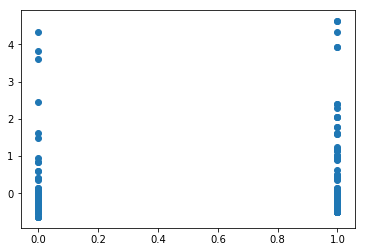

In [65]:
import matplotlib.pyplot
import pylab

x = X_test[:, features.index('Fare')]
y = y_test

matplotlib.pyplot.scatter(y, x)

matplotlib.pyplot.show()

In [79]:
len(np.where(X_test[:, features.index('Fare')] <0 )[0])

227

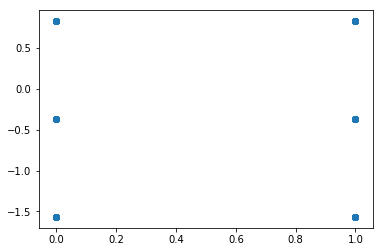

In [69]:
import matplotlib.pyplot
import pylab

x = X_test[:, features.index('Pclass')]
y = y_test

matplotlib.pyplot.scatter(y, x)

matplotlib.pyplot.show()